In [1]:
import xarray as xr
import numpy as np
import math
from scipy.ndimage.filters import gaussian_filter

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

## Constants and functions

In [3]:
G=6.67408*1e-11
# [m**3]
def volume_sphere(r):
    return 4./3*math.pi*r**3
# delta_density [g/cm**3] -> mass [kg]
def delta_mass_sphere(r, delta_density):
    return 1000.*delta_density*volume_sphere(r)
# [мГал]
def delta_grav(delta_mass, x,y,z):
    return (100.*1000)*G*delta_mass*z/np.power(x**2 + y**2 + z**2, 1.5)

def raster_gamma_range(raster0, g1, g2):
    raster = raster0.copy()
    raster.values = raster.values.astype(np.float32)
    raster.values = gaussian_filter(raster.values,g1,mode='constant', cval=np.nan) \
            - gaussian_filter(raster.values,g2,mode='constant', cval=np.nan)
    return raster

## Make synthetic gravity

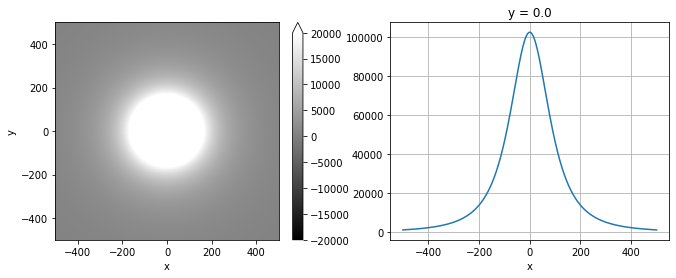

In [4]:
L = 500
l = np.linspace(-L,L,2*L+1)
(x,y) = np.meshgrid(l,l)

h = 120
dh = 60
r = 3.663

dg = delta_grav(delta_mass_sphere(r,1), x, y, h)

dga = xr.DataArray(dg, coords={'y': l[::-1], 'x': l}, dims=['y','x'])
dga.values = (2**30-1)*dga
dga.values = np.flipud(np.round(dga.values)).astype(np.int32)

f, ((ax1, ax2)) = plt.subplots(1,2, figsize=(11,4))
dga.sel(x=slice(-500,500),y=slice(500,-500)).plot(ax=ax1, cmap='gray',vmin=-20000,vmax=20000)
dga.sel(y=0).plot(ax=ax2)
plt.grid()

## Plots

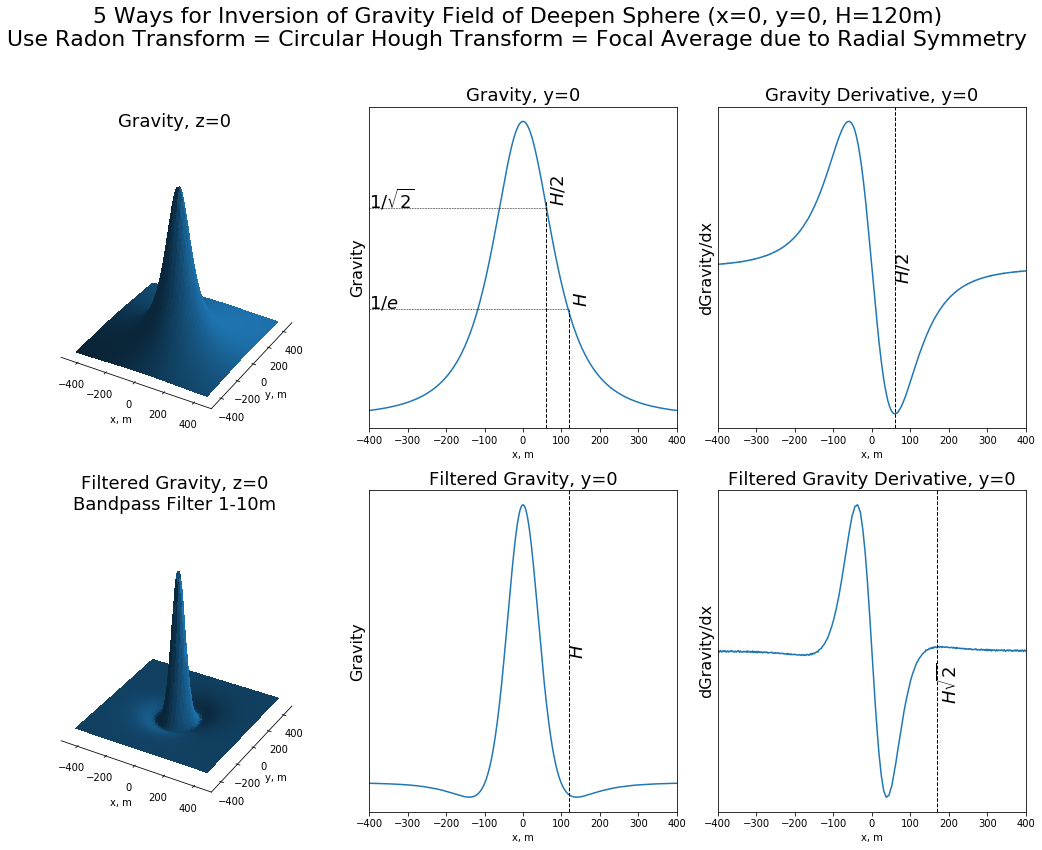

In [5]:
fdga = raster_gamma_range(dga, 1,10)

fig = plt.figure(figsize=(15,12))

ax1 = fig.add_subplot(2, 3, 1, projection='3d')
#dga.sel(x=slice(-500,500),y=slice(500,-500)).plot(ax=ax1, cmap='gray',vmin=0,vmax=20000, add_colorbar=False)
da = dga.sel(x=slice(-450,450),y=slice(450,-450))
(X,Y) = np.meshgrid(da.x,da.y)
Z=da.values
surf = ax1.plot_surface(X, Y, Z,linewidth=0, antialiased=False)
ax1.set_title('Gravity, z=0', fontsize=18)
ax1.set_xlabel('x, m')
ax1.set_ylabel('y, m')
# make the panes transparent
ax1.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax1.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax1.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax1.grid(False)
ax1.w_zaxis.line.set_lw(0.)
ax1.set_zticks([])
#ax1.axis('off')

ax2 = fig.add_subplot(2, 3, 2)
dga.sel(y=0).plot(ax=ax2)
ax2.set_title('Gravity, y=0', fontsize=18)
ax2.set_xlim([-400,400])
ax2.set_yticks([], [])
ax2.set_xlabel('x, m')
ax2.set_ylabel('Gravity', fontsize=16)

ax3 = fig.add_subplot(2, 3, 3)
dga.diff(dim='x').sel(y=0).plot(ax=ax3)
ax3.set_title('Gravity Derivative, y=0', fontsize=18)
ax3.set_xlim([-400,400])
ax3.set_yticks([], [])
ax3.set_xlabel('x, m')
ax3.set_ylabel('dGravity/dx', fontsize=16)

ax4 = fig.add_subplot(2, 3, 4, projection='3d')
da = fdga.sel(x=slice(-450,450),y=slice(450,-450))
(X,Y) = np.meshgrid(da.x,da.y)
Z=da.values
surf = ax4.plot_surface(X, Y, Z,linewidth=0, antialiased=False)
ax4.set_title('Filtered Gravity, z=0\nBandpass Filter 1-10m', fontsize=18)
ax4.set_xlabel('x, m')
ax4.set_ylabel('y, m')
# make the panes transparent
ax4.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax4.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax4.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax4.grid(False)
ax4.w_zaxis.line.set_lw(0.)
ax4.set_zticks([])
#ax4.axis('off')

ax5 = fig.add_subplot(2, 3, 5)
fdga.sel(y=0).plot(ax=ax5)
ax5.set_title('Filtered Gravity, y=0', fontsize=18)
ax5.set_xlim([-400,400])
ax5.set_yticks([], [])
ax5.set_xlabel('x, m')
ax5.set_ylabel('Gravity', fontsize=16)

ax6 = fig.add_subplot(2, 3, 6)
fdga.diff(dim='x').sel(y=0).plot(ax=ax6)
ax6.set_title('Filtered Gravity Derivative, y=0', fontsize=18)
ax6.set_xlim([-400,400])
ax6.set_yticks([], [])
ax6.set_xlabel('x, m')
ax6.set_ylabel('dGravity/dx', fontsize=16)

for ax in [ax3]:
    for x0 in [120/2]:
        ax.axvline(x=x0, c='black',lw=1,ls='--')
        ax.text(x0, (ax.get_ylim()[0]+ax.get_ylim()[1])/2,
            r"$H/2$", rotation=90, verticalalignment='center',fontsize=18)

for ax in [ax5]:
    for x0 in [120]:
        ax.axvline(x=x0, c='black',lw=1,ls='--')
        ax.text(x0, (ax.get_ylim()[0]+ax.get_ylim()[1])/2,
            r"$H$", rotation=90, verticalalignment='center',fontsize=18)

for ax in [ax6]:
    for x0 in [120*1.41]:
        ax.axvline(x=x0, c='black',lw=1,ls='--')
        ax.text(x0, (ax.get_ylim()[0]+0.6*ax.get_ylim()[1])/2,
            r"$H\sqrt{2}$", rotation=90, verticalalignment='center',fontsize=18)

ax2.axvline(x=120, ymin=0, ymax=1/math.e, c='black',lw=1,ls='--')
ax2.text(120+10, (ax2.get_ylim()[0]+0.8*ax2.get_ylim()[1])/2,
    r"$H$", rotation=90, verticalalignment='center',fontsize=18)
ax2.axhline(y=dga.sel(y=0).max()/math.e, xmin=0, xmax=520/800., c='black',lw=0.5,ls='--')
ax2.text(-400, dga.sel(y=0).max()/math.e, r"$1/e$", fontsize=18)

ax2.axvline(x=120*0.5, ymin=0, ymax=1/math.sqrt(2), c='black',lw=1,ls='--')
ax2.text(120/2+10, (ax2.get_ylim()[0]+1.5*ax2.get_ylim()[1])/2,
    r"$H/2$", rotation=90, verticalalignment='center',fontsize=18)
ax2.axhline(y=dga.sel(y=0).max()/math.sqrt(2), xmin=0, xmax=460/800., c='black',lw=0.5,ls='--')
ax2.text(-400, dga.sel(y=0).max()/math.sqrt(2), r"$1/\sqrt{2}$", fontsize=18)

plt.suptitle('5 Ways for Inversion of Gravity Field of Deepen Sphere (x=0, y=0, H=120m)'+
             '\nUse Radon Transform = Circular Hough Transform = Focal Average due to Radial Symmetry', fontsize=22)
fig.tight_layout(rect=[0.03, 0.0, 1, 0.9])
plt.savefig('5 Ways for Inversion of Gravity Field of Deepen Sphere 3d.jpg', quality=95)
plt.show()